<h1><center>King County Housing Price Prediction</center></h1>
<h1><center>Siddhartha Pant</center></h1>

## Introduction

This project uses linear regression modeling techniques to model and predict housing prices in King County, WA. 

In this project, I first took a statistical approach to build a multiple regression model to predict housing prices against various relevant regressors from the dataset. Relevant regressors were chosen based on the standard assumptions of a linear regression model, including suggestive evidence of linearity and absence of strong multicollinearity. The performance of this model was then evaluated on three main model evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and Adjusted R Squared. Fitted versus residual plot, histogram of residuals and a q-q plot of residuals were also drawn to check for normality of the errors. In addition, a Durbin-Watson test was performed to check for presence of autocorrelation in the errors. Although not particularly important to ascertain predictive ability, I also checked if all the coefficients in the model were statistically significant. 

I then built three additional models based on machine learning approaches to see if a model with better predictive ability or a more sparse model with comparable predictive ability could be obtained. In the second model, I built a linear model by performing recursive feature elimination using MAE as a scoring metric to perform backward selection. In the third model, I built an elastic net regularization model using Grid Search Cross Validation using MAE as a scoring metric. The third model yielded an output that suggested that Lasso Regression model could yield a more sparse model with comparable predictive ability. As a result, for the fourth model, I implemented a Lasso Regression Model with Cross Validation.

In cross validation, I used MAE as the scoring metric as the pricing data is right skewed and contains outliers, which are generally valid given the large disparity in real estate prices in any given region, and that some houses tend to be very expensive. Although I reported RMSE as a model evaluation metric, using RMSE as a scoring metric unfairly penalizes the outliers in the model.

## Data Set

The data set for the project is obtained from Kaggle: https://www.kaggle.com/harlfoxem/housesalesprediction

The description of the columns in the data set is obtained from:
https://www.kaggle.com/harlfoxem/housesalesprediction/discussion/207885

The data includes includes housing data for houses sold in the county between 2014 and 2015. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from joblib import dump

In [2]:
# ignoring display of warnings for cleaner output
import warnings;
warnings.filterwarnings('ignore');

## Data Import

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
with open ('column definitions.rtf','r') as f:
    print(f.read())

{\rtf1\ansi\ansicpg1252\cocoartf2576
\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fswiss\fcharset0 Helvetica;}
{\colortbl;\red255\green255\blue255;\red0\green0\blue0;\red255\green255\blue255;}
{\*\expandedcolortbl;;\cssrgb\c0\c0\c0\c70196;\cssrgb\c100000\c100000\c100000;}
\margl1440\margr1440\vieww13640\viewh8400\viewkind0
\deftab720
\pard\pardeftab720\partightenfactor0

\f0\fs28 \cf2 \cb3 \expnd0\expndtw0\kerning0
\outl0\strokewidth0 \strokec2 id - Unique ID for each home sold\
date - Date of the home sale\
price - Price of each home sold\
bedrooms - Number of bedrooms\
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower\
sqft_living - Square footage of the apartments interior living space\
sqft_lot - Square footage of the land space\
floors - Number of floors\
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not\
view - An index from 0 to 4 of how good the view of the property was\
condition - An index fr

## Data Wrangling and Feature Exploration

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


I drop the ID column as it just includes unique identifier for the the rows, and does not add any value in describing the price. 

In [8]:
df.drop(columns = ['id'],inplace = True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Since location (captured by zip code) is often an important determinant in determining prices of a property in any location with disparity in property prices, I would like to include zipcode as an explanatory feature in the model as a categorical variable. I cast that to string data type.

In [9]:
df['zipcode'] = df['zipcode'].astype('string')

It seems unlikey for real estate transaction to occur in 'cents'. After checking for the fact that the prices contain no data with decimal points, I cast that as integer. 

In [10]:
df[df['price'] % 1 != 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [11]:
df['price'] = df['price'].astype('int64')

In the data column, the data that is of most interest to me is the year the house was sold, which will in turn allow me to gauge the 'age' of the house, given the fact that I have data on when the house was built. As the goal of this project is not to puruse time series analysis on changes in housing prices over months and day, I will assume that the data is mostly cross sectional in nature.

I slice the data in the date column to get the year sold, and calculate the 'age' of the house. I drop the year_sold and yr_built feature.

In [12]:
df['date'] = df['date'].str.slice(start = 0,stop = 4)
df.rename(columns={"date": "year_sold"},inplace = True)
df['year_sold'] = df['year_sold'].astype('int64')

In [13]:
df['age'] = df['year_sold'] - df['yr_built']
df.drop(columns = ['year_sold','yr_built'],inplace = True)

In [14]:
df[df['yr_renovated'] > 0]['yr_renovated'].describe()

count     914.000000
mean     1995.827133
std        15.517107
min      1934.000000
25%      1987.000000
50%      2000.000000
75%      2007.000000
max      2015.000000
Name: yr_renovated, dtype: float64

It is evident that few houses have a history of being renovated given the size of the dataset. Even within houses that have been renovated, a substantial portion of the houses were renovated long ago to have any meaningful impact on current housing prices. I assume that renovation made in the past 10 years should matter. 

I create a feature called categorical feature called 'recent_renovation_status', which will include dummy value of '1' if the house has been renovated since 2004, and '0' otherwise. I then drop the year renovated column from the data.

In [15]:
df['recent_renovation_status'] = df.apply(lambda x : 1 if x['yr_renovated'] >= 2004 else 0 ,axis = 1)
df.drop(columns = ['yr_renovated'],inplace = True)

In [16]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,59,0
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,63,0
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,82,0
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,49,0
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,28,0


In [17]:
zipcode_stats = df.groupby('zipcode')['zipcode'].agg('count').sort_values()
zipcode_stats

zipcode
98039     50
98148     57
98024     81
98010    100
98102    105
        ... 
98117    553
98052    574
98115    583
98038    590
98103    602
Name: zipcode, Length: 70, dtype: int64

There are some zipcodes in the data for which there isn't enough data points relative to the data from other zipcodes. I chose to group and label the zipcode column for all data with zipcodes that have a value count of less than 125 as 'Other'. This will also reduce the dimension of the dataset by 8 categorical features. 

In [18]:
zipcode_less_than_125 = zipcode_stats[zipcode_stats <= 125]
zipcode_less_than_125

zipcode
98039     50
98148     57
98024     81
98010    100
98102    105
98109    109
98070    118
98014    124
98032    125
Name: zipcode, dtype: int64

In [19]:
df['zipcode'] = df['zipcode'].apply(lambda x: 'Other' if x in zipcode_less_than_125 else x)

In [20]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,59,0
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,63,0
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,82,0
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,49,0
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,98103,47.6993,-122.346,1530,1509,5,0
21609,400000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,98146,47.5107,-122.362,1830,7200,1,0
21610,402101,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,98144,47.5944,-122.299,1020,2007,5,0
21611,400000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,98027,47.5345,-122.069,1410,1287,11,0


### Exploratory Data Analysis

In [21]:
df['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

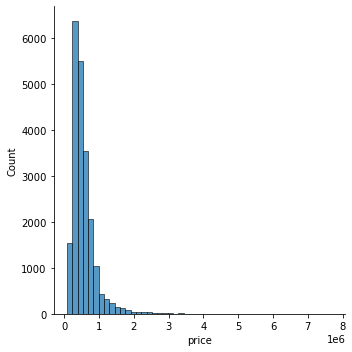

In [22]:
sns.displot(df['price'],bins = 50)

<AxesSubplot:xlabel='price'>

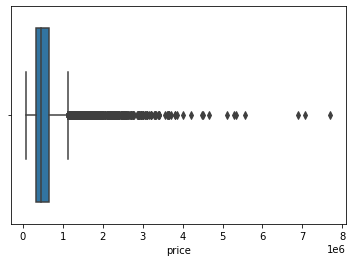

In [23]:
sns.boxplot(df['price'])

In [24]:
print('Skewness of Price:',df['price'].skew())
print('Kurtosis of Price:',df['price'].kurtosis())

Skewness of Price: 4.024069144684712
Kurtosis of Price: 34.58554043194243


The histogram, boxplot, skewness and kurtosis of price all indicate that the data for the price is right skewed, which is typical of pricing related data. To explore the data further, I calculate the Average price per square foot of the data and explore its distribution.

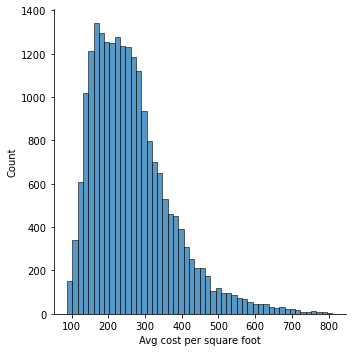

In [25]:
df['Avg cost per square foot'] = df['price'] / df['sqft_living']
sns.displot(df['Avg cost per square foot'],bins = 50)

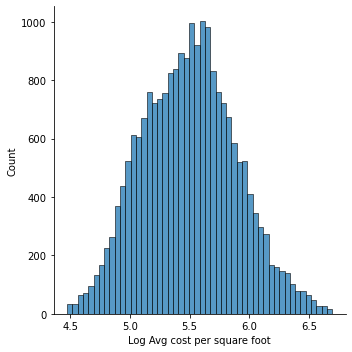

In [26]:
# normalizing the distribution by logarithmic transformation
df['Log Avg cost per square foot'] = np.log(df['price'] / df['sqft_living'])
sns.displot(df['Log Avg cost per square foot'],bins = 50)

To remove outliers in data related to price, for each zipcode, I remove any data below or above 1.96 standard deviations fom the mean of the log average cost per square foot to capture the middle 95% of the pricing dataset for each zipcode.

In [27]:
def remove_price_outliers(df):
    output_df = pd.DataFrame()
    for key, subdf in df.groupby('zipcode'):
        m = np.mean(subdf['Log Avg cost per square foot'])
        s = (np.std(subdf['Log Avg cost per square foot']))
        filtered_df = subdf[(subdf['Log Avg cost per square foot'] >= (m - (1.645*s))) 
                    & (subdf['Log Avg cost per square foot'] <= (m + (1.645*s)))]
        output_df = pd.concat([output_df,filtered_df],ignore_index = True)
    return output_df

df = remove_price_outliers(df)
df.drop(columns = ['Avg cost per square foot','Log Avg cost per square foot'],inplace = True)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
0,240000,4,1.00,1220,8075,1.0,0,0,2,7,890,330,98001,47.3341,-122.282,1290,7800,46,0
1,287000,4,2.50,2240,4648,2.0,0,0,3,7,2240,0,98001,47.3378,-122.257,2221,4557,9,0
2,480000,4,2.50,3230,16171,2.0,0,3,3,9,2520,710,98001,47.3183,-122.253,2640,8517,13,0
3,465000,3,2.50,2714,17936,2.0,0,0,3,9,2714,0,98001,47.3185,-122.275,2590,18386,10,0
4,360000,4,2.50,2160,9528,2.0,0,0,3,9,2160,0,98001,47.3341,-122.255,2280,9937,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,130208,2.0,0,0,3,10,4620,0,Other,47.5885,-121.939,4620,131007,1,0
19567,1865000,4,3.75,3790,8797,2.0,0,0,3,11,3290,500,Other,47.6351,-122.236,2660,12150,9,0
19568,710200,4,3.00,1670,2642,2.0,0,0,3,8,1350,320,Other,47.6397,-122.345,1670,2594,7,0
19569,399950,2,1.00,710,1157,2.0,0,0,4,7,710,0,Other,47.6413,-122.329,1370,1173,71,0


To examine correrlation between the variables, I plot a diagonal correlation matrix. I further calculate the exact correlation values of price and other potential explanatory variables. 

<AxesSubplot:>

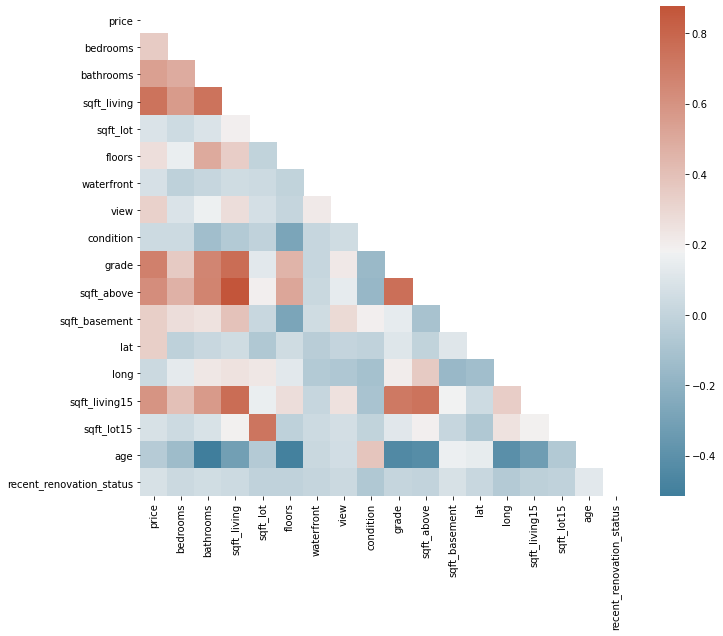

In [28]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap,square=True)

In [29]:
df.corr()['price'].sort_values(ascending = False)

price                       1.000000
sqft_living                 0.740023
grade                       0.682941
sqft_above                  0.624174
sqft_living15               0.597853
bathrooms                   0.540677
bedrooms                    0.350167
lat                         0.337579
sqft_basement               0.333378
view                        0.322657
floors                      0.264179
sqft_lot                    0.092144
recent_renovation_status    0.082080
sqft_lot15                  0.081444
waterfront                  0.074351
condition                   0.037137
long                        0.030232
age                        -0.051435
Name: price, dtype: float64

To explore the relationships between price and potential explanatory variables, I examine scatter plots of the variable with price, starting with variables that are most highly correletated with price. Since the relationships of price with most ordinal features and categorical variables are not immediately evident from a scatter plot, I further explore those features with a boxplot. Outliers are identified, explored and removed from the data set.

<AxesSubplot:xlabel='zipcode', ylabel='price'>

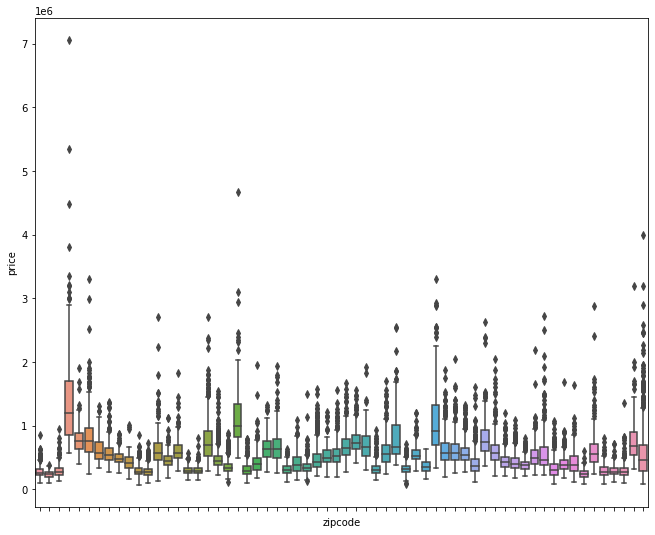

In [30]:
f, ax = plt.subplots(figsize=(11, 9))
zipcode_boxplot = sns.boxplot(x = "zipcode",y="price",data =df)
zipcode_boxplot.set(xticklabels=[])
zipcode_boxplot

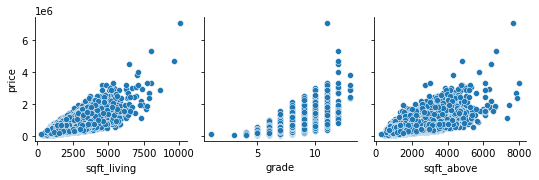

In [31]:
sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['sqft_living','grade','sqft_above'])

<AxesSubplot:xlabel='grade', ylabel='price'>

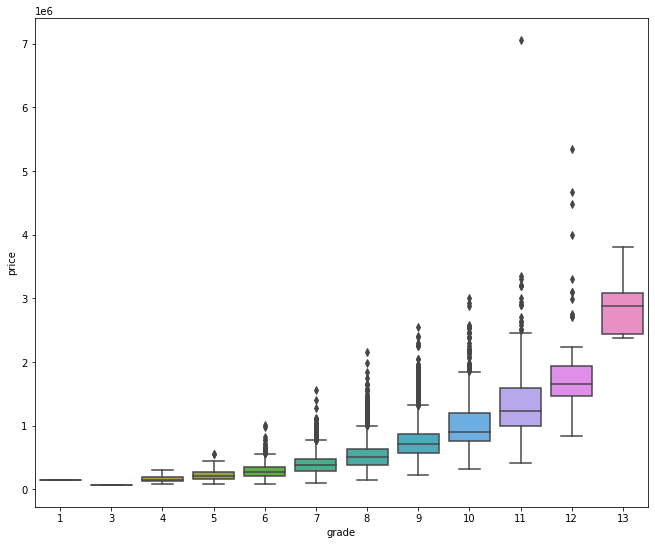

In [32]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "grade",y="price",data =df)

In [33]:
df[df['sqft_living'] > 10000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
801,7062500,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,98004,47.65,-122.214,3930,25449,74,0


In [34]:
df[(df['grade'] >= 10) & (df['price'] < 450000)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
85,420000,4,2.5,2480,8626,2.0,0,0,3,10,2480,0,98001,47.3185,-122.262,2990,9033,13,0
726,389000,4,2.5,2420,9147,2.0,0,0,3,10,2420,0,98003,47.3221,-122.322,1400,7200,16,0
2596,405000,3,2.5,3170,12750,2.0,0,0,3,10,2360,810,98023,47.3384,-122.336,2970,13125,19,0
2623,402500,4,2.5,2600,11951,2.0,0,0,3,10,2600,0,98023,47.3053,-122.340,2820,12093,26,0
2855,445000,3,2.5,2790,16173,2.0,0,0,3,10,2790,0,98023,47.3043,-122.343,2890,11632,26,0
2996,420000,4,2.5,3360,11637,2.0,0,0,3,11,3360,0,98023,47.3018,-122.342,3530,11205,25,0
3007,442000,4,4.0,4168,8485,2.0,0,0,3,10,3222,946,98023,47.3029,-122.387,4362,8100,7,0
4161,422000,4,2.5,2930,5973,2.0,0,0,3,10,2930,0,98030,47.3846,-122.186,3038,7095,7,0
6211,425000,3,2.5,2670,13218,1.0,0,0,4,10,2670,0,98042,47.3683,-122.153,1960,13130,26,0
6420,396500,3,2.5,2590,18980,1.0,0,0,4,10,2590,0,98042,47.3839,-122.153,3110,14652,38,0


In [35]:
df[df['sqft_above'] > 7000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
801,7062500,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,98004,47.6500,-122.214,3930,25449,74,0
1583,3300000,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,98006,47.5675,-122.189,4160,18969,13,0
3311,2700000,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,98027,47.5406,-121.982,6210,95832,9,0
6699,1950000,4,3.25,7420,167869,2.0,0,3,3,12,7420,0,98045,47.4548,-121.764,5610,169549,13,0
8692,1135250,5,4.00,7320,217800,2.0,0,0,3,11,7320,0,98058,47.4473,-122.086,3270,34500,22,0
17811,2415000,5,4.75,7880,24250,2.0,0,2,3,13,7880,0,98177,47.7334,-122.362,2740,10761,19,0


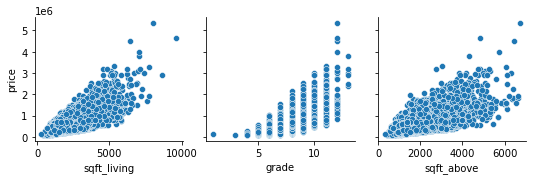

In [36]:
# Removing the identified outliers
df = df.drop(df[df['sqft_living'] > 10000].index)
df = df.drop(df[(df['grade'] >= 10) & (df['price'] < 450000)].index)
df = df.drop(df[df['sqft_above'] > 7000].index)

sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['sqft_living','grade','sqft_above'])

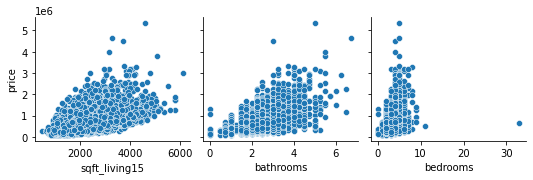

In [37]:
pp = sns.pairplot(data=df,
                  y_vars=['price'],
                  x_vars= ['sqft_living15','bathrooms','bedrooms'])

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

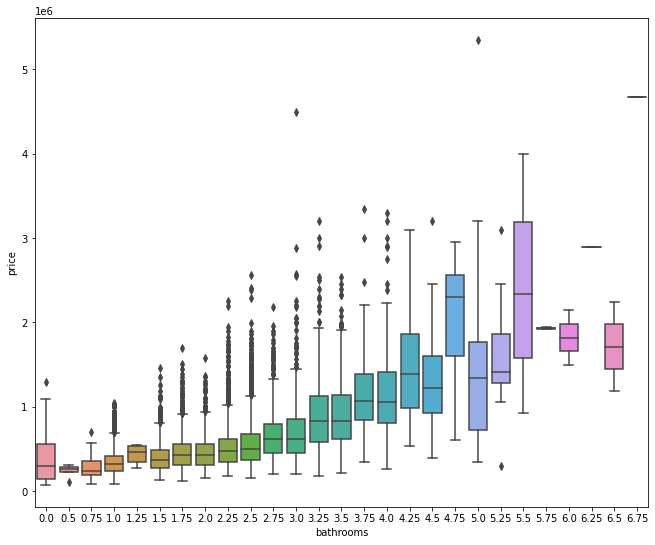

In [38]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "bathrooms",y="price",data =df)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

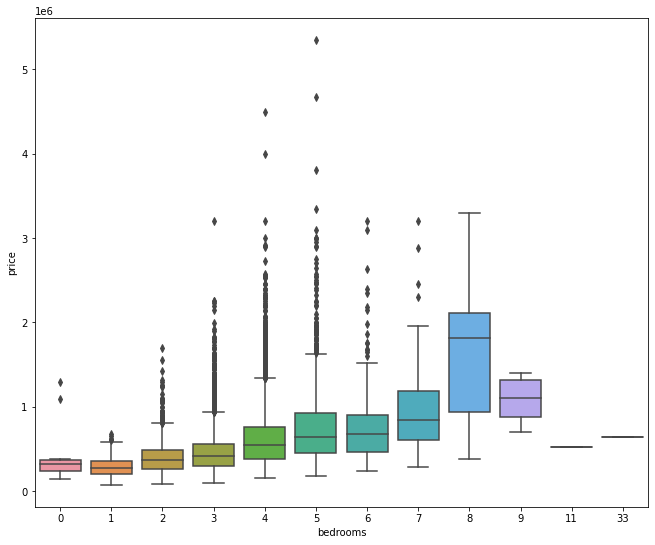

In [39]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "bedrooms",y="price",data =df)

In [40]:
df['sqft_living15'].describe()

count    19553.000000
mean      1984.805350
std        676.029831
min        460.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6110.000000
Name: sqft_living15, dtype: float64

In [41]:
df[df['sqft_living15'] < 500]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
15070,257500,2,2.0,1180,9265,1.0,0,0,3,7,1180,0,98125,47.7252,-122.297,460,18000,74,0


In [42]:
df['bathrooms'].describe()

count    19553.000000
mean         2.124086
std          0.742409
min          0.000000
25%          1.750000
50%          2.250000
75%          2.500000
max          6.750000
Name: bathrooms, dtype: float64

In [43]:
df[df['bathrooms'] == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
198,139950,0,0.0,844,4269,1.0,0,0,4,7,844,0,98001,47.2781,-122.250,1380,9600,102,0
2373,75000,1,0.0,670,43377,1.0,0,0,3,3,670,0,98022,47.2638,-121.906,1160,42882,49,0
4282,355000,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,98031,47.4095,-122.168,2520,8050,25,0
7439,1295650,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,98053,47.6642,-122.069,4740,35061,24,0
9243,235000,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,98065,47.5265,-121.828,1060,7200,18,0
15608,380000,0,0.0,1470,979,3.0,0,2,3,8,1470,0,98133,47.7145,-122.356,1470,1399,9,0
18811,1095000,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,Other,47.6362,-122.322,2360,4000,24,0
19508,142000,0,0.0,290,20875,1.0,0,0,1,1,290,0,Other,47.5308,-121.888,1620,22850,51,0


In [44]:
df[df['bathrooms'] > 6]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
3390,2238890,5,6.50,7270,130017,2.0,0,0,3,12,6420,850,98027,47.5371,-121.982,1800,44890,4,0
5929,4668000,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,98040,47.5570,-122.210,3270,10454,31,1
10421,1180000,6,6.50,6260,10955,2.0,0,0,3,11,4840,1420,98075,47.5947,-122.039,2710,12550,8,0
17821,2888000,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,98177,47.7295,-122.372,4140,81021,49,0


In [45]:
df[df['bedrooms'] == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
198,139950,0,0.0,844,4269,1.0,0,0,4,7,844,0,98001,47.2781,-122.250,1380,9600,102,0
4282,355000,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,98031,47.4095,-122.168,2520,8050,25,0
5504,240000,0,2.5,1810,5669,2.0,0,0,3,7,1810,0,98038,47.3493,-122.053,1810,5685,11,0
6279,339950,0,2.5,2290,8319,2.0,0,0,3,8,2290,0,98042,47.3473,-122.151,2500,8751,29,0
7439,1295650,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,98053,47.6642,-122.069,4740,35061,24,0
9243,235000,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,98065,47.5265,-121.828,1060,7200,18,0
9273,320000,0,2.5,1490,7111,2.0,0,0,3,7,1490,0,98065,47.5261,-121.826,1500,4675,16,0
14909,288000,0,1.5,1430,1650,3.0,0,0,3,7,1430,0,98125,47.7222,-122.290,1430,1650,15,0
15608,380000,0,0.0,1470,979,3.0,0,2,3,8,1470,0,98133,47.7145,-122.356,1470,1399,9,0
18811,1095000,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,Other,47.6362,-122.322,2360,4000,24,0


In [46]:
df[df['bedrooms'] > 10]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
11285,640000,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,98103,47.6878,-122.331,1330,4700,67,0
11794,520000,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,98106,47.5560,-122.363,1420,4960,96,0


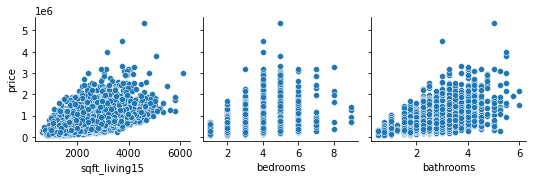

In [47]:
# Removing the identified outliers
df = df.drop(df[df['sqft_living15'] < 500].index)
df = df.drop(df[df['bathrooms'] == 0].index)
df = df.drop(df[df['bathrooms'] > 6].index)
df = df.drop(df[df['bedrooms'] == 0].index)
df = df.drop(df[df['bedrooms'] > 10].index)

sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['sqft_living15','bedrooms','bathrooms'])

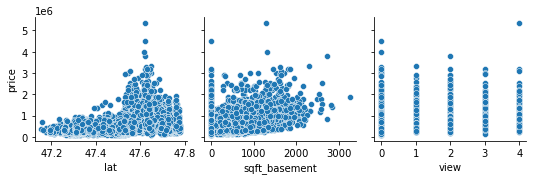

In [48]:
sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['lat','sqft_basement','view'])

<AxesSubplot:xlabel='view', ylabel='price'>

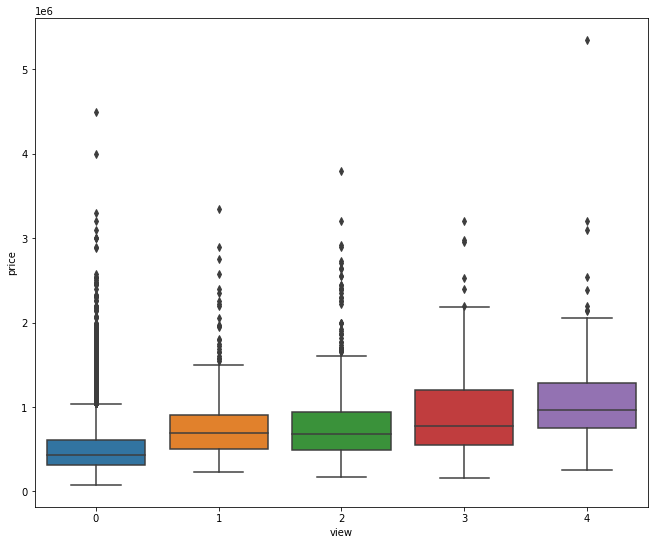

In [49]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "view",y="price",data =df)

In [50]:
df[df['sqft_basement'] > 3000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
5954,1900000,5,4.25,6510,16471,2.0,0,3,4,11,3250,3260,98040,47.5758,-122.242,4480,16471,34,0


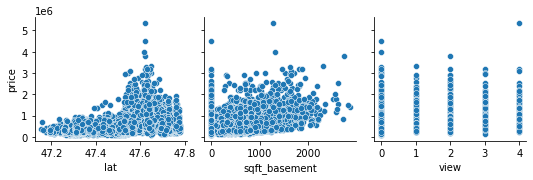

In [51]:
# Removing identified outliers
df = df.drop(df[df['sqft_basement'] > 3000].index)

pp = sns.pairplot(data=df,
                  y_vars=['price'],
                  x_vars= ['lat','sqft_basement','view'])

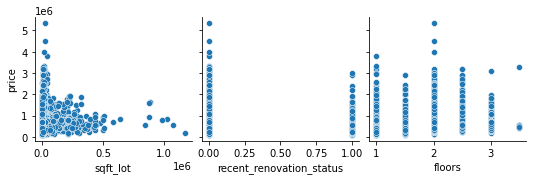

In [52]:
sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['sqft_lot','recent_renovation_status','floors'])

<AxesSubplot:xlabel='recent_renovation_status', ylabel='price'>

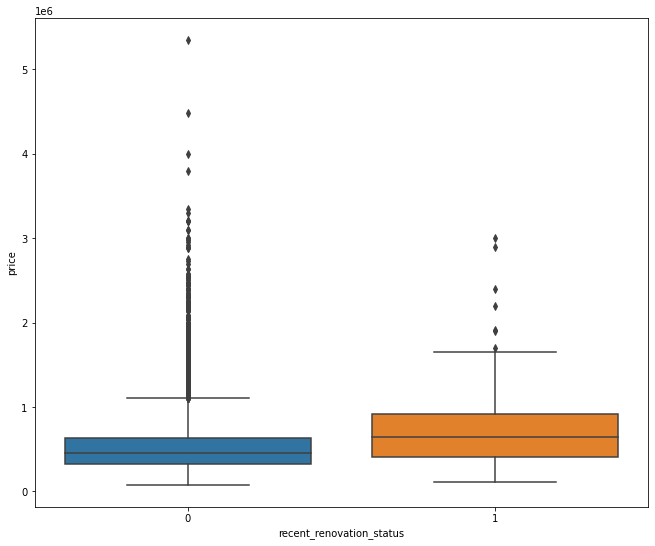

In [53]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "recent_renovation_status",y="price",data =df)

<AxesSubplot:xlabel='floors', ylabel='price'>

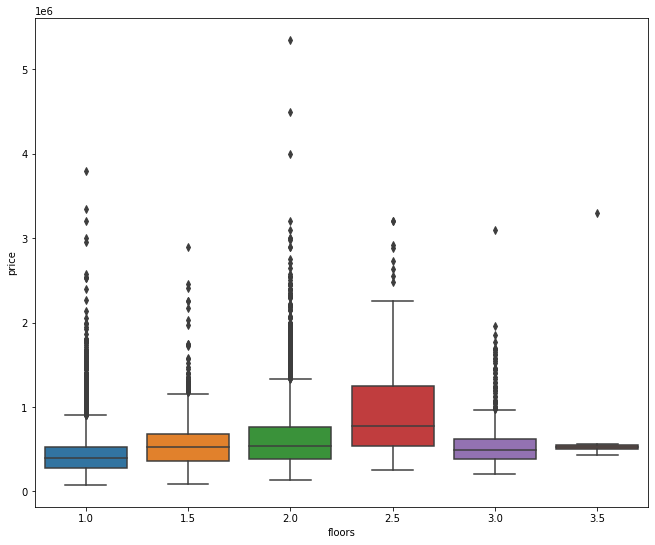

In [54]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "floors",y="price",data =df)

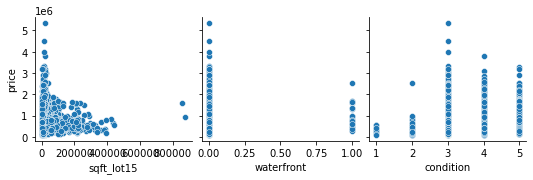

In [55]:
sns.pairplot(data=df,
            y_vars=['price'],
            x_vars= ['sqft_lot15','waterfront','condition'])

<AxesSubplot:xlabel='waterfront', ylabel='price'>

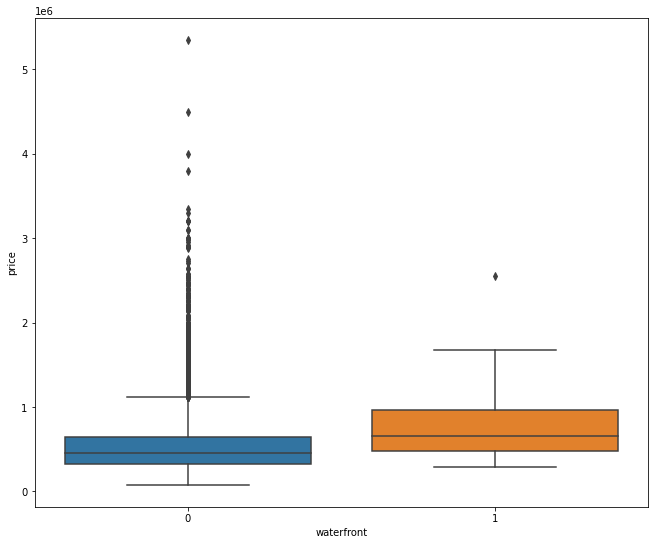

In [56]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "waterfront",y="price",data =df)

<AxesSubplot:xlabel='condition', ylabel='price'>

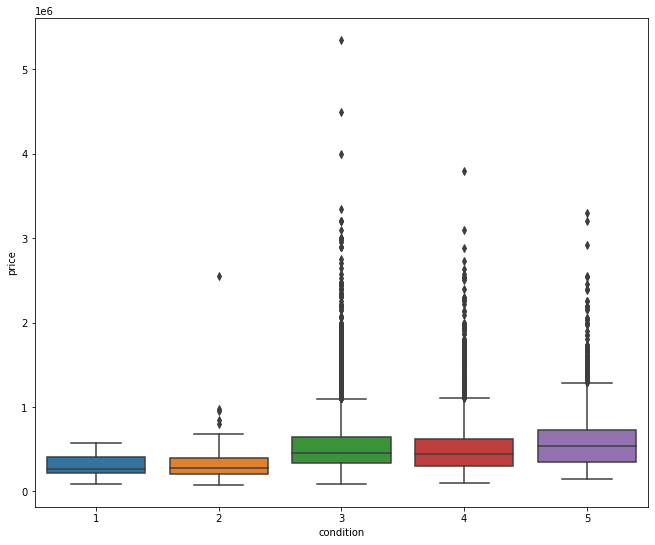

In [57]:
f, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x = "condition",y="price",data =df)

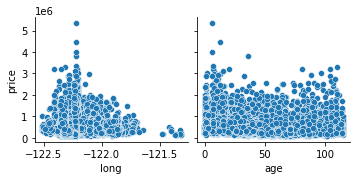

In [58]:
pp = sns.pairplot(data=df,
                  y_vars=['price'],
                  x_vars= ['long','age'])

In [59]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,recent_renovation_status
0,240000,4,1.00,1220,8075,1.0,0,0,2,7,890,330,98001,47.3341,-122.282,1290,7800,46,0
1,287000,4,2.50,2240,4648,2.0,0,0,3,7,2240,0,98001,47.3378,-122.257,2221,4557,9,0
2,480000,4,2.50,3230,16171,2.0,0,3,3,9,2520,710,98001,47.3183,-122.253,2640,8517,13,0
3,465000,3,2.50,2714,17936,2.0,0,0,3,9,2714,0,98001,47.3185,-122.275,2590,18386,10,0
4,360000,4,2.50,2160,9528,2.0,0,0,3,9,2160,0,98001,47.3341,-122.255,2280,9937,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,130208,2.0,0,0,3,10,4620,0,Other,47.5885,-121.939,4620,131007,1,0
19567,1865000,4,3.75,3790,8797,2.0,0,0,3,11,3290,500,Other,47.6351,-122.236,2660,12150,9,0
19568,710200,4,3.00,1670,2642,2.0,0,0,3,8,1350,320,Other,47.6397,-122.345,1670,2594,7,0
19569,399950,2,1.00,710,1157,2.0,0,0,4,7,710,0,Other,47.6413,-122.329,1370,1173,71,0


In order to use zipcode as a categorical predictor in the regression model, I transform the zipcode data using one-hot encoding to generate dummy variables for the data.

In [60]:
df_zipcode_dummies = pd.get_dummies(df['zipcode'])
df_zipcode_dummies.drop('Other',axis = 1,inplace = True)

## Modeling

### Model 1: Multiple Linear Regression Model

The first model I built was a Multiple Linear Regression Model, by selecting features based on the findings of the Data Wrangling and Feature Exploration Section.

In [61]:
df_model_one = df.copy()

For the following five features, I was unable to see any clear evidence of a linear relationship with price. As a result, based on the linearity evidence, I drop these features from the data set. 
- sqft_lot
- sqft_lot15
- Floors
- Age
- Long

In [62]:
df_model_one = df_model_one.drop(columns = ['sqft_lot','sqft_lot15','floors','age','long'],axis = 1)

Next, I explore the correlation matrix to eliminate any features for strong multicollinearity.

In [63]:
correlation_matrix = df_model_one.drop('price', axis=1).corr()
correlation_matrix

,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,recent_renovation_status
bedrooms,1.000000,0.505076,0.586001,-0.023539,0.093293,0.032121,0.366923,0.485044,0.277197,-0.017780,0.419069,0.031996
bathrooms,0.505076,1.000000,0.740494,0.004667,0.167763,-0.133741,0.661579,0.667887,0.246013,0.020399,0.567951,0.051910
sqft_living,0.586001,0.740494,1.000000,0.028013,0.266517,-0.057911,0.770639,0.873747,0.385723,0.049815,0.774318,0.035903
waterfront,-0.023539,0.004667,0.028013,1.000000,0.209549,0.018746,0.008924,0.013551,0.031529,-0.038495,0.012820,0.003576
view,0.093293,0.167763,0.266517,0.209549,1.000000,0.046772,0.221043,0.137273,0.284137,0.003382,0.255266,0.027662
condition,0.032121,-0.133741,-0.057911,0.018746,0.046772,1.000000,-0.158108,-0.166637,0.197774,-0.010810,-0.096279,-0.069622
grade,0.366923,0.661579,0.770639,0.008924,0.221043,-0.158108,1.000000,0.758563,0.135599,0.111784,0.714623,0.010951
sqft_above,0.485044,0.667887,0.873747,0.013551,0.137273,-0.166637,0.758563,1.000000,-0.111718,-0.006135,0.741700,-0.003209
sqft_basement,0.277197,0.246013,0.385723,0.031529,0.284137,0.197774,0.135599,-0.111718,1.000000,0.113415,0.175104,0.079440
lat,-0.017780,0.020399,0.049815,-0.038495,0.003382,-0.010810,0.111784,-0.006135,0.113415,1.000000,0.043776,0.020045


In [64]:
correlated_features = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.append(colname)
            
correlated_features

['sqft_above']

As squarefoot above seems to be highly correlated with square foot living, I decide to drop this feature from the data set. This also seems reasonable as there are already seperate features for square foot living and square foot basement. As a result, the impact of square foot above can be assumed to be reasonably captured by these two features.

In [65]:
df_model_one = df_model_one.drop(columns = ['sqft_above'],axis = 1)

In [66]:
df_model_one.corr()['price'].sort_values(ascending = False)

price                       1.000000
sqft_living                 0.735589
grade                       0.688187
sqft_living15               0.602086
bathrooms                   0.539567
bedrooms                    0.362908
lat                         0.343853
sqft_basement               0.327161
view                        0.320565
recent_renovation_status    0.079096
waterfront                  0.041079
condition                   0.039917
Name: price, dtype: float64

In [67]:
# including the dummy encoded features of zipcode and dropping the zipcode column
df_model_one_dummy_encoded = pd.concat([df_model_one,df_zipcode_dummies],axis = 'columns')
df_model_one_dummy_encoded.drop('zipcode',axis = 1, inplace = True)

In [68]:
df_model_one_dummy_encoded

,price,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,sqft_basement,lat,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,240000,4,1.00,1220,0,0,2,7,330,47.3341,...,0,0,0,0,0,0,0,0,0,0
1,287000,4,2.50,2240,0,0,3,7,0,47.3378,...,0,0,0,0,0,0,0,0,0,0
2,480000,4,2.50,3230,0,3,3,9,710,47.3183,...,0,0,0,0,0,0,0,0,0,0
3,465000,3,2.50,2714,0,0,3,9,0,47.3185,...,0,0,0,0,0,0,0,0,0,0
4,360000,4,2.50,2160,0,0,3,9,0,47.3341,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,0,0,3,10,0,47.5885,...,0,0,0,0,0,0,0,0,0,0
19567,1865000,4,3.75,3790,0,0,3,11,500,47.6351,...,0,0,0,0,0,0,0,0,0,0
19568,710200,4,3.00,1670,0,0,3,8,320,47.6397,...,0,0,0,0,0,0,0,0,0,0
19569,399950,2,1.00,710,0,0,4,7,0,47.6413,...,0,0,0,0,0,0,0,0,0,0


Based on this final data set for the model, I begin the modeling process for Model One. As the features in the data have signficantly different scales, I have scaled the data using standarization. With the standarized data, I fit the regression model and run 5-fold cross validation and report MAE, RMSE and Adjusted R squared as metrics for model performance. 

In [69]:
X_one = df_model_one_dummy_encoded.drop('price',axis = 1)
y_one = df_model_one_dummy_encoded['price']

In [70]:
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X_one, y_one, 
                                            test_size=0.2, random_state=42)

In [71]:
scaler = StandardScaler()
X_train_one = scaler.fit_transform(X_train_one)
X_test_one = scaler.fit_transform(X_test_one)

In [72]:
model_one = LinearRegression() 
model_one.fit(X_train_one,y_train_one)

LinearRegression()

In [73]:
scores_one = cross_validate(model_one,X_train_one,y_train_one,scoring = 
            ['neg_mean_absolute_error','neg_mean_squared_error','explained_variance'],cv = 5)

In [74]:
scores_one = pd.DataFrame(scores_one)
scores_one

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_explained_variance
0,0.025750,0.002105,-80525.522852,-1.447211e+10,0.850694
1,0.019924,0.001187,-84368.938376,-1.640276e+10,0.834785
2,0.021092,0.001732,-83457.545734,-1.869659e+10,0.825552
3,0.021252,0.001562,-80970.467008,-1.549446e+10,0.838013
4,0.019529,0.001364,-82185.926775,-1.562654e+10,0.840420


In [75]:
scores_one.mean()

fit_time                        2.150941e-02
score_time                      1.590061e-03
test_neg_mean_absolute_error   -8.230168e+04
test_neg_mean_squared_error    -1.613849e+10
test_explained_variance         8.378928e-01
dtype: float64

In [76]:
print("Model One Evaluation Metrics Based on Cross Validation: ")
MAE = (scores_one.mean()['test_neg_mean_absolute_error'] * -1)
RMSE = np.sqrt((scores_one.mean()['test_neg_mean_squared_error'] * -1))
Adj_R_Squared = (scores_one.mean()['test_explained_variance'])

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model One Evaluation Metrics Based on Cross Validation: 
MAE:  82301.68
RMSE:  127037.37
Adjusted R Squared:  0.838


In [77]:
y_pred_model_one = model_one.predict(X_test_one)
resid_one = y_test_one - y_pred_model_one

In [78]:
print("Model One Evaluation Metrics Based on Test Data: ")
MAE = mean_absolute_error(y_test_one,y_pred_model_one)
RMSE = np.sqrt(mean_squared_error(y_test_one,y_pred_model_one))
Adj_R_Squared = r2_score(y_test_one,y_pred_model_one)

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model One Evaluation Metrics Based on Test Data: 
MAE:  83537.69
RMSE:  126174.32
Adjusted R Squared:  0.832


I plot the fitted vs residuals plot, the histogram of residuals, and the q-q plot of the residuals to check the normality of residuals assumption of regression model. Although the residuals do not seem to be completely normally distributed, I still consider the model to be an acceptable linear regression model. Fitted vs residuals plot show indication of a simple random scatter. The residuals are skewed by the presence of large outliers, which is typical of pricing in the real estate related data. 

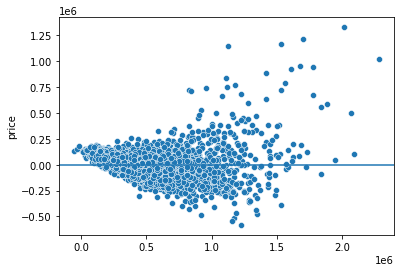

In [79]:
fitted_vs_residuals = sns.scatterplot(x = y_pred_model_one, y = resid_one)
fitted_vs_residuals.axhline(0)

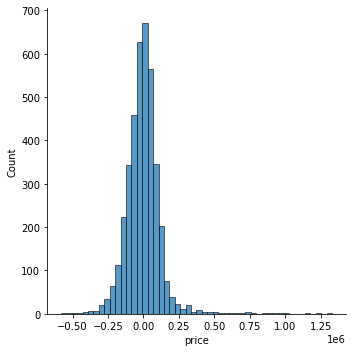

In [80]:
sns.displot(resid_one,bins = 50)

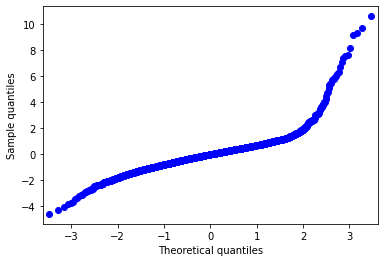

In [81]:
fig=qqplot(resid_one,fit='True')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

I also ran a Durbin Watson Test on the residuals to check for any autocorrelation. A value very close to 2 indicates that the residuals are not auto-correlated. 

In [82]:
print("Durbin-Watson Coefficient: ", durbin_watson(resid_one).round(3))

Durbin-Watson Coefficient:  2.019


Although not particularly important to ascertain predictive ability, I also viewed a more comprehensive regression result summary by fitting the model through statsmodels library as the regression model was built using a statistical approach. I particularly checked if the coefficients in the model were statistically significant. With the exception of coefficients pertaining to some zipcodes, all other coefficients seem to be statistically significant. 

In [83]:
sm_reg_mod = sm.OLS(y_train_one,sm.add_constant(X_train_one))
results = sm_reg_mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1131.
Date:                Wed, 06 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:05:38   Log-Likelihood:            -2.0571e+05
No. Observations:               15626   AIC:                         4.116e+05
Df Residuals:                   15553   BIC:                         4.121e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.296e+05   1012.130    523.219      0.0

## Model 2: Recursive Feature Elimination 

The second model I built was a linear model by using cross validated recursive feature elimination using scikit learn using MAE as a scoring metric. I used all the features in the data to feed into the algorithm without pursuing any form of feature selection manually. As the features in the data have signficantly different scales, I have scaled the data using standarization.

In [84]:
df_model_two = df.copy()

In [85]:
df_model_two_dummy_encoded = pd.concat([df_model_two,df_zipcode_dummies],axis = 'columns')
df_model_two_dummy_encoded.drop('zipcode',axis = 1, inplace = True)

In [86]:
df_model_two_dummy_encoded

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,240000,4,1.00,1220,8075,1.0,0,0,2,7,...,0,0,0,0,0,0,0,0,0,0
1,287000,4,2.50,2240,4648,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
2,480000,4,2.50,3230,16171,2.0,0,3,3,9,...,0,0,0,0,0,0,0,0,0,0
3,465000,3,2.50,2714,17936,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
4,360000,4,2.50,2160,9528,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,130208,2.0,0,0,3,10,...,0,0,0,0,0,0,0,0,0,0
19567,1865000,4,3.75,3790,8797,2.0,0,0,3,11,...,0,0,0,0,0,0,0,0,0,0
19568,710200,4,3.00,1670,2642,2.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
19569,399950,2,1.00,710,1157,2.0,0,0,4,7,...,0,0,0,0,0,0,0,0,0,0


In [87]:
X_two = df_model_two_dummy_encoded.drop(columns = ['price'],axis = 1)
y_two = df_model_two_dummy_encoded['price']

In [88]:
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two,y_two,test_size = 0.2,random_state = 42)

In [89]:
scaler = StandardScaler()
X_train_two = scaler.fit_transform(X_train_two)
X_test_two = scaler.fit_transform(X_test_two)

In [90]:
model_two_prelim = LinearRegression() 
model_two_prelim.fit(X_train_two,y_train_two)

LinearRegression()

In [91]:
model_two_rfe = RFECV(estimator = model_two_prelim,step = 1,scoring = 'neg_mean_absolute_error')
model_two_rfe.fit(X_train_two,y_train_two)

RFECV(estimator=LinearRegression(), scoring='neg_mean_absolute_error')

In [92]:
print("Optimal number of features: ",model_two_rfe.n_features_)

Optimal number of features:  76


The cross validated recursive feature elimination algorithm led to an optimal number of features of 76, thereby resulting in comparable number of features as Model 1. I plotted the graph of feature selection against Negative MAE, which indicates very little change in MAE after around 50 features, suggesting that there could be room to make the model more sparse, whilst maintaing comparable MAE values.

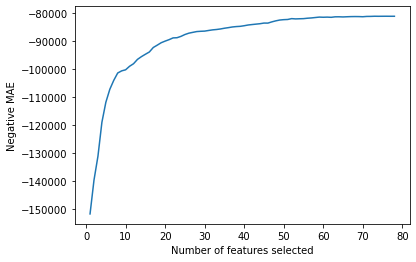

In [93]:
plt.xlabel('Number of features selected')
plt.ylabel('Negative MAE')
plt.plot(range(1, len(model_two_rfe.grid_scores_) + 1), model_two_rfe.grid_scores_)
plt.show()

Fitting the model achieved through recursive feature selection on the training data set and evaluating its performance on the testing set through a 5 fold cross validation:

In [94]:
model_two = model_two_rfe.estimator_
model_two.fit(X_train_two,y_train_two)

LinearRegression()

In [95]:
scores_two = cross_validate(model_two,X_train_two,y_train_two,scoring = ['neg_mean_absolute_error','neg_mean_squared_error','explained_variance'],cv = 5)

In [96]:
scores_two = pd.DataFrame(scores_two)
scores_two

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_explained_variance
0,0.021523,0.001571,-79075.236905,-1.369070e+10,0.858752
1,0.024706,0.001285,-82910.283153,-1.574218e+10,0.841431
2,0.023538,0.001631,-82298.606216,-1.798515e+10,0.832268
3,0.022027,0.001234,-79996.472558,-1.501899e+10,0.842912
4,0.020319,0.001205,-81115.617785,-1.502194e+10,0.846479


In [97]:
scores_two.mean()

fit_time                        2.242260e-02
score_time                      1.385117e-03
test_neg_mean_absolute_error   -8.107924e+04
test_neg_mean_squared_error    -1.549179e+10
test_explained_variance         8.443684e-01
dtype: float64

In [98]:
print("Model Two Evaluation Metrics on Cross Validated Data: ")
MAE = (scores_two.mean()['test_neg_mean_absolute_error'] * -1)
RMSE = np.sqrt((scores_two.mean()['test_neg_mean_squared_error'] * -1))
Adj_R_Squared = (scores_two.mean()['test_explained_variance'])

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model Two Evaluation Metrics on Cross Validated Data: 
MAE:  81079.24
RMSE:  124466.03
Adjusted R Squared:  0.844


Based on the results of the cross validation, Model 2 doesn't seem to provide any form of improvement in terms of feature reduction or changes in model evaluation metrics. As a result, I do not explore Model 2 any further and move on to Model 3 to explore the option of regularization via a Elastic Net model.

## Model 3: Elastic Net Regularization using Grid Search Cross Validation

The third model I built was an elastic net regularization model using Grid Search Cross Validation using MAE as a scoring metric using scikit learn. I used all the features in the data to feed into the algorithm without pursuing any form of feature selection manually. As with previous models, the features in the data have signficantly different scales, I have scaled the data using standarization.

In [99]:
df_model_three = df.copy()

In [100]:
df_model_three_dummy_encoded = pd.concat([df_model_three,df_zipcode_dummies],axis = 'columns')
df_model_three_dummy_encoded.drop('zipcode',axis = 1, inplace = True)

In [101]:
df_model_three_dummy_encoded

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,240000,4,1.00,1220,8075,1.0,0,0,2,7,...,0,0,0,0,0,0,0,0,0,0
1,287000,4,2.50,2240,4648,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
2,480000,4,2.50,3230,16171,2.0,0,3,3,9,...,0,0,0,0,0,0,0,0,0,0
3,465000,3,2.50,2714,17936,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
4,360000,4,2.50,2160,9528,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,130208,2.0,0,0,3,10,...,0,0,0,0,0,0,0,0,0,0
19567,1865000,4,3.75,3790,8797,2.0,0,0,3,11,...,0,0,0,0,0,0,0,0,0,0
19568,710200,4,3.00,1670,2642,2.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
19569,399950,2,1.00,710,1157,2.0,0,0,4,7,...,0,0,0,0,0,0,0,0,0,0


In [102]:
X_three = df_model_three_dummy_encoded.drop(columns = ['price'],axis = 1)
y_three = df_model_three_dummy_encoded['price']

In [103]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(
    X_three, y_three, test_size=0.2, random_state=42)

In [104]:
scaler = StandardScaler()
X_train_three = scaler.fit_transform(X_train_three)
X_test_three = scaler.fit_transform(X_test_three)

In [105]:
base_model_three = ElasticNet(max_iter = 1000000)
param_grid = {'alpha':[0.1,1,5,10,50,100],
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

For consistency I use (negative) MAE as a scoring metric and perform cross validation across 5 folds.

In [106]:
grid_model_three = GridSearchCV(base_model_three,
                         param_grid = param_grid,
                         scoring = 'neg_mean_absolute_error',
                         cv = 5, verbose = 1)

In [107]:
grid_model_three.fit(X_train_three,y_train_three)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 71.5min finished


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=1000000),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_absolute_error', verbose=1)

The grid search indicated a l1 ratio of 0.99 and an alpha parameter value of 10 for the Elastic Net Regression. This indicates that the regularization tends very significantly towards Lasso Regression with L1 regularization.

In [146]:
grid_model_three.best_params_

{'alpha': 10, 'l1_ratio': 0.99}

In [147]:
grid_model_three.best_estimator_.coef_

array([ -6898.52943231,  19120.05007463,  74143.18966022,   3750.46404399,
        -4520.50409822,   2774.61508767,  28250.21350175,  12158.07556793,
        57263.85179921,  68205.4968726 ,  22249.17041013,  50749.81300395,
       -19033.41967388,  18001.25411478,  -4047.48737544,  27845.36235703,
         8516.25621564, -12916.97664298,  -7028.22171968, -13911.49117468,
        63279.83792517,   7306.68760759,  10121.22059148,   2665.78485757,
         3127.15859881, -12347.4983761 , -11671.12040386,  -2822.99011523,
       -22059.77596832,   1082.41793155, -15985.05885948,   4338.78234665,
       -11163.57931494, -13526.8754101 ,  14440.25726672,  -9662.4799535 ,
       -10752.93807564,  32090.35795046, -15077.65626526,    197.68272745,
         -178.68729501,    169.08081096, -12432.257822  ,  -9579.9528768 ,
       -16226.03718697, -10504.83255431,  -5435.25549826, -10812.9456319 ,
        -2907.93051977,  -2014.53767951,  -8863.16810166, -16086.94995519,
         9382.79463936,  

In [110]:
y_pred_model_three = grid_model_three.predict(X_test_three)
resid_three = y_test_three - y_pred_model_three

In [111]:
print("Model Three Evaluation Metrics on Test Data: ")
MAE = mean_absolute_error(y_test_three,y_pred_model_three)
RMSE = np.sqrt(mean_squared_error(y_test_three,y_pred_model_three))
Adj_R_Squared = r2_score(y_test_three,y_pred_model_three)

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model Three Evaluation Metrics on Test Data: 
MAE:  80775.63
RMSE:  125447.37
Adjusted R Squared:  0.834


It is evident from the output that the Elastic Net Model doesn't lead to any substantial improvement in model evaluation metrics and doesn't achieve any form of sparsity. However, the results from the Grid Search which yields a l_1 ratio of 0.99 indicates that the model tends very closely to Lasso Regression.  

### Model 4: Lasso Regression

Based on the results of the Elastic Net Regression from Model 3, it seems fitting to run a Lasso Regression Model with L1 Regularization on the data set to explore the possibility of arriving at a model with comparable/better predictive ability with more sparse coefficients.

I used all the features in the data to feed into the algorithm without pursuing any form of feature selection manually. As with previous models, the features in the data have signficantly different scales, I have scaled the data using standarization.

In [112]:
df_model_four = df.copy()

In [113]:
df_model_four_dummy_encoded = pd.concat([df_model_three,df_zipcode_dummies],axis = 'columns')
df_model_four_dummy_encoded.drop('zipcode',axis = 1, inplace = True)

In [114]:
df_model_four_dummy_encoded

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,240000,4,1.00,1220,8075,1.0,0,0,2,7,...,0,0,0,0,0,0,0,0,0,0
1,287000,4,2.50,2240,4648,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
2,480000,4,2.50,3230,16171,2.0,0,3,3,9,...,0,0,0,0,0,0,0,0,0,0
3,465000,3,2.50,2714,17936,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
4,360000,4,2.50,2160,9528,2.0,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,1459000,4,4.00,4620,130208,2.0,0,0,3,10,...,0,0,0,0,0,0,0,0,0,0
19567,1865000,4,3.75,3790,8797,2.0,0,0,3,11,...,0,0,0,0,0,0,0,0,0,0
19568,710200,4,3.00,1670,2642,2.0,0,0,3,8,...,0,0,0,0,0,0,0,0,0,0
19569,399950,2,1.00,710,1157,2.0,0,0,4,7,...,0,0,0,0,0,0,0,0,0,0


In [115]:
X_four = df_model_four_dummy_encoded.drop(columns = ['price'],axis = 1)
y_four = df_model_four_dummy_encoded['price']

In [116]:
X_train_four, X_test_four, y_train_four, y_test_four = train_test_split(
    X_four, y_four, test_size=0.2, random_state=42)

In [117]:
scaler = StandardScaler()
X_train_four = scaler.fit_transform(X_train_four)
X_test_four = scaler.fit_transform(X_test_four)

Several iterations of the Lasso Model cross validated with 5 folds is run and the hyperparameters are adjusted based on the output and performance of the model

In [118]:
lasso_cv_model_four1 = LassoCV(eps = 0.001,n_alphas = 10, cv = 5,max_iter = 100000)

In [119]:
lasso_cv_model_four1.fit(X_train_four,y_train_four)

LassoCV(cv=5, max_iter=100000, n_alphas=10)

In [120]:
lasso_cv_model_four1.alpha_

232.53142215825525

In [121]:
y_pred_model_four1 = lasso_cv_model_four1.predict(X_test_four)
resid_four1 = y_test_four - y_pred_model_four1

In [122]:
print("Model Four Evaluation Metrics on Test Data - First Iteration")
MAE = mean_absolute_error(y_test_four,y_pred_model_four1)
RMSE = np.sqrt(mean_squared_error(y_test_four,y_pred_model_four1))
Adj_R_Squared = r2_score(y_test_four,y_pred_model_four1)

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model Four Evaluation Metrics on Test Data - First Iteration
MAE:  82102.26
RMSE:  123928.6
Adjusted R Squared:  0.838


In [123]:
lasso_cv_model_four1.coef_

array([-12867.70466046,  13323.23332252, 132786.68041428,   2923.05539725,
       -12506.0772216 ,   2203.14906485,  29620.21130597,  12535.8675348 ,
        56447.27464661,  41468.86039568,      0.        ,  96152.40816138,
       -33866.11654285,   4788.81042823,  -5194.41984194,  25466.01338359,
         8336.01700798,  -8546.25958149,  -3158.17531589, -11092.02818564,
        62459.72186544,   4138.01913881,   6970.9862445 ,   -143.51706966,
        -1230.15627237, -21931.71489879, -18378.84250419,   7090.43602926,
       -19071.25033072,    755.7698737 , -28418.17254596,   3617.66296874,
        -8550.03008028, -12129.24720677,   5502.28774123, -23835.61218708,
        -3277.28723746,  31000.38811627,  -9894.80177305,   3949.53974239,
       -10011.58994326,  -7829.61073876, -13135.69397141, -12389.89043232,
       -15953.62176932, -12020.58894015,  -4352.89834956, -21645.04185111,
        -8408.92620763,  -5284.79876576, -17431.2472713 , -10382.35971224,
        -2158.18709665,  

The hyperparameters to the Lasso CV Model on the first iteration yielded a model that is a similar to Models 1, 2 and 3 in terms of model evaluation metrics, but did not result in a sparse model. Tuning the hyper parameters further:

In [124]:
lasso_cv_model_four2 = LassoCV(eps = 0.01,n_alphas = 10, cv = 5,max_iter = 100000)

In [125]:
lasso_cv_model_four2.fit(X_train_four,y_train_four)

LassoCV(cv=5, eps=0.01, max_iter=100000, n_alphas=10)

In [126]:
lasso_cv_model_four2.alpha_

2325.314221582553

In [127]:
y_pred_model_four2 = lasso_cv_model_four2.predict(X_test_four)
resid_four2 = y_test_four - y_pred_model_four2

In [128]:
print("Model Four Evaluation Metrics on Test Data - Second Iteration")
MAE = mean_absolute_error(y_test_four,y_pred_model_four2)
RMSE = np.sqrt(mean_squared_error(y_test_four,y_pred_model_four2))
Adj_R_Squared = r2_score(y_test_four,y_pred_model_four2)

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model Four Evaluation Metrics on Test Data - Second Iteration
MAE:  82642.3
RMSE:  126380.03
Adjusted R Squared:  0.832


In [129]:
lasso_cv_model_four2.coef_

array([ -8806.12425726,   9437.78440562, 140269.94564037,      0.        ,
           -0.        ,   1432.88112129,  29612.62284315,  11064.2757101 ,
        63977.08288054,  23623.59685831,      0.        ,  86616.85237505,
       -14837.1533501 ,   1292.51908626,     -0.        ,  32682.3918618 ,
         6270.98743623,     -0.        ,      0.        ,  -2634.04127492,
        68312.79006187,   6890.87817795,  12569.07791209,   1545.13581079,
         2175.11821062, -13216.89012608, -12982.00422278,   5754.60361396,
        -7633.26432577,   3092.36759715, -17716.10176663,   5068.70114167,
        -1801.44907064,  -4976.95880698,  12502.75858465, -10696.06728158,
            0.        ,  35881.91617907,  -2167.0265165 ,   1262.51617689,
           -0.        ,     -0.        ,  -5713.7259722 ,  -3034.37963098,
        -7703.06352392,  -2607.12504865,   -191.90181138, -12418.63060252,
         -249.80071051,      0.        , -10108.24898927,  -3579.2547448 ,
         5951.44052556,  

In [130]:
features_eliminated = len(lasso_cv_model_four2.coef_) - np.count_nonzero(lasso_cv_model_four2.coef_)
features_eliminated

12

The hyperparameters to the Lasso CV Model on the second iteration yielded a model that is a similar to Models 1, 2 and 3 in terms of model evaluation metrics and resulted in a model with 12 features that have a coefficient of zero. The model is more sparse compared to the models from 1, 2 and 3. Tuning the hyperparameters further to explore further scopes of sparsity:

In [131]:
lasso_cv_model_four3 = LassoCV(eps = 0.02,n_alphas = 10, cv = 5,max_iter = 100000)

In [132]:
lasso_cv_model_four3.fit(X_train_four,y_train_four)

LassoCV(cv=5, eps=0.02, max_iter=100000, n_alphas=10)

In [133]:
lasso_cv_model_four3.alpha_

4650.628443165106

In [134]:
y_pred_model_four3 = lasso_cv_model_four3.predict(X_test_four)
resid_four3 = y_test_four - y_pred_model_four3

In [135]:
print("Model Four Evaluation Metrics on Test Data - Third Iteration")
MAE = mean_absolute_error(y_test_four,y_pred_model_four3)
RMSE = np.sqrt(mean_squared_error(y_test_four,y_pred_model_four3))
Adj_R_Squared = r2_score(y_test_four,y_pred_model_four3)

print("MAE: ",MAE.round(2))
print("RMSE: ",RMSE.round(2))
print("Adjusted R Squared: ",Adj_R_Squared.round(3))

Model Four Evaluation Metrics on Test Data - Third Iteration
MAE:  85442.87
RMSE:  129923.32
Adjusted R Squared:  0.822


In [136]:
lasso_cv_model_four3.coef_

array([-3.76703266e+03,  7.34803097e+03,  1.40503152e+05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.94599645e+04,  8.92240958e+03,
        7.07636481e+04,  1.53801694e+04,  0.00000000e+00,  8.32949777e+04,
       -6.46318794e+03,  0.00000000e+00, -0.00000000e+00,  3.42567251e+04,
        4.40321833e+03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        6.72010747e+04,  4.95864873e+03,  1.08038656e+04,  0.00000000e+00,
        2.66017047e+01, -9.79955745e+03, -1.06045359e+04,  2.42698905e+03,
       -3.83557300e+03,  5.91594603e+02, -1.37816195e+04,  2.36567741e+03,
       -0.00000000e+00, -2.30680735e+03,  1.15608899e+04, -6.80768391e+03,
        0.00000000e+00,  3.45372231e+04, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -2.87496198e+03, -0.00000000e+00,
       -5.28324222e+03, -0.00000000e+00, -0.00000000e+00, -9.15607196e+03,
       -0.00000000e+00,  0.00000000e+00, -7.16604151e+03, -1.16882167e+03,
        6.28462826e+03,  

In [137]:
features_eliminated = len(lasso_cv_model_four3.coef_) - np.count_nonzero(lasso_cv_model_four3.coef_)
features_eliminated

26

The hyperparameters to the Lasso CV Model on the third iteration yielded a model that is significantly more sparse with 26 features and fairly comparable (very slightly inferior) model evaluation metrics to Models 1, 2 and 3.

## Model Selection and Conclusion

All four models yielded very comparable MAE, RMSE and Adjusted R squared values. However, the third iteration of Model 4, yielded a significantly more sparse model with a similar degree of predictive abiity. The regularization achieved through Lasso Regression provides a cushion against overtfitting. In addition, the sparsity of the model also helps alleviate some of the issues sorrounding multicollinearity that was present in the original data. 

It can be observed that the price data has a standard deviation of approximately 314,000. As a result, a MAE of around 85,442.87 is fairly reasonable. Based on the findings of the four models, I ultimately chose the third iteration of Model 4 to be the most optimal model.

In [138]:
df['price'].describe()

count    1.953300e+04
mean     5.285832e+05
std      3.137814e+05
min      8.000000e+04
25%      3.250000e+05
50%      4.500000e+05
75%      6.400000e+05
max      5.350000e+06
Name: price, dtype: float64

Running final model diagnostics on the chosen model to ensure that it doesn't violate assumptions of a linear regression model:

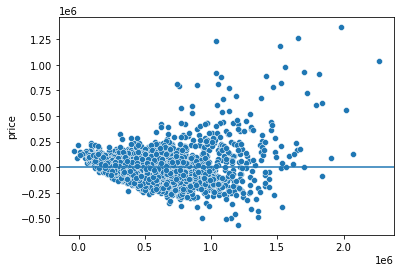

In [139]:
fitted_vs_residuals = sns.scatterplot(x = y_pred_model_four3, y = resid_four3)
fitted_vs_residuals.axhline(0)

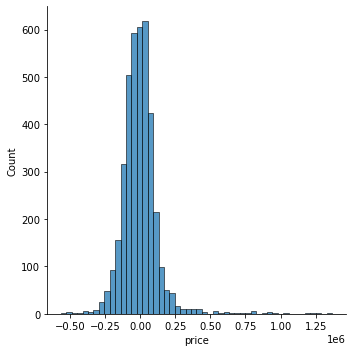

In [140]:
sns.displot(resid_four3,bins = 50)

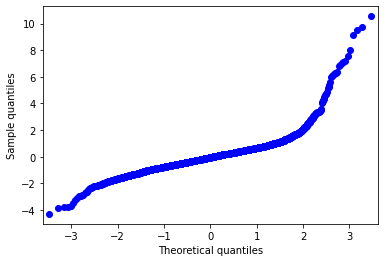

In [141]:
fig=qqplot(resid_four3,fit='True')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

In [142]:
print("Durbin-Watson Coefficient: ", durbin_watson(resid_four3).round(3))

Durbin-Watson Coefficient:  2.047


Although the residuals do not seem to be completely normally distributed, the model seems to be an acceptable linear regression model for the data set we are dealing with. Fitted vs residuals plot show indication of a simple random scatter. The residuals are skewed by the presence of large outliers, which is typical of pricing in the real estate related data. The Durbin-Watson Coefficient value of approximately 2 also indicates that the residuals are not auto-correlated. 

## Final Model 

Fitting the final model on the entire dataset and saving the fitted model as a joblib file:

In [143]:
final_model = lasso_cv_model_four3

In [144]:
final_model.fit(X_four,y_four)

LassoCV(cv=5, eps=0.02, max_iter=100000, n_alphas=10)

In [145]:
dump(final_model,'final_housing_prediction_model.joblib')

['final_housing_prediction_model.joblib']